# Run Analyses of Canada-Wide GTFS Data

Author: Kevin Dick

The general analysis pipeline will first load the cleaned CSD spreadsheet containing IDs for those CSDs that have validated GTFS data. Thereafter, the archived GTFS data is converted into an SQLight database format that functions with the `gtfspy` library. We then iterate over all CSDs and extract summary statistics for their GTFS offerings. Finally, a number of correlation analyses are run using the Statistics Canada census data and the GTFS offerings in these regions.

In [94]:
import os
import pandas as pd
from gtfspy import import_gtfs
from gtfspy import gtfs, stats
from gtfspy import osm_transfers

In [95]:
# Load the cleaned dataset of CSD information
df_raw = pd.read_csv('../data/CSD-tabulation-cleaned.csv', encoding='latin1')
df_clean = df_raw[df_raw['Id'].notna()].reset_index()
df_clean.head(5)

,index,Id,GeographicCode,GeographicName,CSDType,ProvinceTerritory,GeographicCodeProvinceTerritory,GeographicCodeCensusDivision,Population2016,Population2011,...,TotalPrivateDwellings2016,TotalPrivateDwellings2011,TotalPrivateDwellingsPercentChange,PrivateDwellingsOccupiedByUsualResidents2016,PrivateDwellingsOccupiedByUsualResidents2011,PrivateDwellingsOccupiedByUsualResidentsPercentChange,LandAreaInSquareKilometres2016,PopulationDensityPerSquareKilometre2016,NationalPopulationRank2016,ProvincialTerritorialPopulationRank2016
0,0,Toronto-ON,3520005,Toronto,City,Ontario,35,3520,2731571,2615060,...,1179057,1107851,6.4,1112929,1047877,6.2,630.20,4334.4,1,1
1,1,Montreal-QC,2466023,Montréal,Ville,Quebec,24,2466,1704694,1649519,...,843872,813819,3.7,779802,759946,2.6,365.65,4662.1,2,1
2,2,Calgary-AB,4806016,Calgary,City,Alberta,48,4806,1239220,1096833,...,489650,445848,9.8,466725,423417,10.2,825.56,1501.1,3,1
3,3,Ottawa-ON,3506008,Ottawa,City,Ontario,35,3506,934243,883391,...,395985,370217,7.0,373756,353244,5.8,2790.30,334.8,4,2
4,4,Edmonton-AB,4811061,Edmonton,City,Alberta,48,4811,932546,812201,...,387950,348672,11.3,360828,324756,11.1,685.25,1360.9,5,2


In [96]:
# Turn all cleaned CSDs into an SQL database variant
base_gtfs_dir = '../data/CSDs-StaticGTFS/'
db_gtfs_dir   = '../data/sqlite-db/'
for index, row in df_clean.iterrows():
    csd_id = row['Id']
    print(f"{'-'*30} Processing {csd_id}")
    imported_database_path = os.path.join(db_gtfs_dir, csd_id)
    if os.path.exists(imported_database_path): # skip those that have already been processed
        print('Already Processed; skipping...\n\n')
        continue

    import_gtfs.import_gtfs([f"{base_gtfs_dir}/{csd_id}/Static_GTFS/{csd_id}.zip"],  # input: list of GTFS zip files (or directories)
                            imported_database_path,  # output: where to create the new sqlite3 database
                            print_progress=True,  # whether to print progress when importing data
                            location_name=csd_id)

    # Now you can access the imported database using a GTFS-object as an interface:
    G = gtfs.GTFS(imported_database_path)
    print(f"{'-'*30} Finished: {G.get_location_name()}\n\n")

------------------------------ Processing Toronto-ON
Beginning AgencyLoader
Importing agency.txt into agencies for 
Indexing agencies
Post-import agency.txt into agencies
Beginning RouteLoader
Importing routes.txt into routes for 
Indexing routes
Beginning MetadataLoader
Indexing metadata
Beginning CalendarLoader
Importing calendar.txt into calendar for 
Indexing calendar
Beginning CalendarDatesLoader
Importing calendar_dates.txt into calendar_dates for 
Beginning ShapeLoader
Importing shapes.txt into shapes for 
Indexing shapes
Post-import shapes.txt into shapes
Beginning FeedInfoLoader
feed_info.txt  missing in  {'zipfile': '../data/CSDs-StaticGTFS//Toronto-ON/Static_GTFS/Toronto-ON.zip', 'zip_commonprefix': ''}
Beginning StopLoader
Importing stops.txt into stops for 
Indexing stops
Post-import stops.txt into stops
Beginning TransfersLoader
transfers.txt  missing in  {'zipfile': '../data/CSDs-StaticGTFS//Toronto-ON/Static_GTFS/Toronto-ON.zip', 'zip_commonprefix': ''}
Beginning StopDi

In [97]:
# The final number of CSDs with validated GTFS data 
df_clean.shape

(82, 21)

In [101]:
# Iterate over all CSDs for which the sqlite-db was successfully created
# Load the GTFS data into an object from which to extract various summary statistics
n_routes  = []
n_stops   = []
n_trips   = []
n_days    = []
height_km = []
width_km  = []
ut_start  = []
ut_end    = []

db_gtfs_dir   = '../data/sqlite-db/'
for index, row in df_clean.iterrows():
    csd_id = row['Id']
    print(f"{'-'*30} getting statistics for {csd_id}")

    imported_database_path = os.path.join(db_gtfs_dir, csd_id)
    G = gtfs.GTFS(imported_database_path)

    stats = G.get_stats()
    print(stats)
    n_routes.append(stats['n_routes'])
    n_stops.append(stats['n_stops'])
    n_trips.append(stats['n_trips'])
    n_days.append(stats['n_days'])
    height_km.append(stats['height_km'])
    width_km.append(stats['width_km'])
    ut_start.append(stats['start_time_ut'])
    ut_end.append(stats['end_time_ut'])

# Append all data as new columns to final dataframe
df_all = df_clean.copy()
df_all['n_routes'] = n_routes
df_all['n_stops'] = n_stops
df_all['n_trips'] = n_trips
df_all['n_days'] = n_days
df_all['height_km'] = height_km
df_all['width_km'] = width_km
df_all['ut_start'] = ut_start
df_all['ut_end'] = ut_end
df_all.head()

------------------------------ getting statistics for Toronto-ON
{'n_agencies': 1, 'n_routes': 188, 'n_stops': 9464, 'n_stop_times': 4242313, 'n_trips': 123210, 'n_calendar': 6, 'n_shapes': 318007, 'n_calendar_dates': 2, 'n_days': 1439969, 'n_stop_distances': 493466, 'n_frequencies': 0, 'n_feed_info': 0, 'n_transfers': 0, 'agencies': 'TTC', 'lat_min': 43.591811, 'lat_10': 43.6494352, 'lat_median': 43.719038, 'lat_90': 43.7987479, 'lat_max': 43.909707, 'lon_min': -79.649908, 'lon_10': -79.5459255, 'lon_median': -79.39900549999999, 'lon_90': -79.25116630000001, 'lon_max': -79.123111, 'height_km': 35.388020845218215, 'width_km': 58.64277379142436, 'start_time_ut': 1602388800, 'end_time_ut': 1606035600, 'start_date': '2020-10-11', 'end_date': '2020-11-21', 'max_activity_date': '2020-10-13', 'max_activity_hour': 8, 'fleet_size_route_based': '0:85 1:42 3:977', 'fleet_size_max_movement': '0:117 1:78 3:1105', 'routes__type__dist': '0:10 1:4 3:174', 'calendar_dates__exception_type__dist': '1:1 

,index,Id,GeographicCode,GeographicName,CSDType,ProvinceTerritory,GeographicCodeProvinceTerritory,GeographicCodeCensusDivision,Population2016,Population2011,...,NationalPopulationRank2016,ProvincialTerritorialPopulationRank2016,n_routes,n_stops,n_trips,n_days,height_km,width_km,ut_start,ut_end
0,0,Toronto-ON,3520005,Toronto,City,Ontario,35,3520,2731571,2615060,...,1,1,188,9464,123210,1439969,35.388021,58.642774,1602388800,1606035600
1,1,Montreal-QC,2466023,Montréal,Ville,Quebec,24,2466,1704694,1649519,...,2,1,219,9034,203003,2938442,33.223079,52.946110,1641186000,1655107200
2,2,Calgary-AB,4806016,Calgary,City,Alberta,48,4806,1239220,1096833,...,3,1,275,6193,23433,412124,36.671089,49.868349,1652076000,1656324000
3,3,Ottawa-ON,3506008,Ottawa,City,Ontario,35,3506,934243,883391,...,4,2,191,5811,29548,387026,43.365176,77.934442,1651809600,1656230400
4,4,Edmonton-AB,4811061,Edmonton,City,Alberta,48,4811,932546,812201,...,5,2,220,6222,64072,511071,44.719155,79.787688,1652421600,1656842400


In [125]:
# Calculate the stops by GTFS coverage density (stops/km^2) and the trip temporal density (trips/ut_window)
df_all['stop_spatial_density'] = df_all.apply(lambda row: row.n_stops / (row.height_km * row.width_km), axis=1)
df_all['trip_temporal_density'] = df_all.apply(lambda row: row.n_trips / (row.ut_end - row.ut_start), axis=1)
df_all.tail()

,index,Id,GeographicCode,GeographicName,CSDType,ProvinceTerritory,GeographicCodeProvinceTerritory,GeographicCodeCensusDivision,Population2016,Population2011,...,n_routes,n_stops,n_trips,n_days,height_km,width_km,ut_start,ut_end,stop_spatial_density,trip_temporal_density
77,185,LAssomption-QC,2460028,L'Assomption,Ville,Quebec,24,2460,22429,20065,...,14,825,1554,33959,34.726672,29.212906,1652155200,1661155200,0.813235,0.000173
78,191,Scugog-ON,3518020,Scugog,Township,Ontario,35,3518,21617,21569,...,27,1739,4375,127095,37.556970,64.458883,1649044800,1655712000,0.718334,0.000656
79,197,Varennes-QC,2459020,Varennes,Ville,Quebec,24,2459,21257,20994,...,15,349,784,19563,57.151204,50.387654,1652414400,1661155200,0.121193,0.000090
80,203,Saint-Lin-Laurentides-QC,2463048,Saint-Lin-Laurentides,Ville,Quebec,24,2463,20786,17463,...,88,2231,7418,123156,39.330067,71.526780,1652673600,1661155200,0.793060,0.000875
81,211,Fort-St-John-BC,5955034,Fort St. John,City,British Columbia,59,5955,20155,18609,...,5,82,227,22889,3.894178,7.886207,1637650800,1672570800,2.670114,0.000007


In [118]:
df_all.columns

Index(['index', 'Id', 'GeographicCode', 'GeographicName', 'CSDType',
       'ProvinceTerritory', 'GeographicCodeProvinceTerritory',
       'GeographicCodeCensusDivision', 'Population2016', 'Population2011',
       'PopulationPercentChange', 'TotalPrivateDwellings2016',
       'TotalPrivateDwellings2011', 'TotalPrivateDwellingsPercentChange',
       'PrivateDwellingsOccupiedByUsualResidents2016',
       'PrivateDwellingsOccupiedByUsualResidents2011',
       'PrivateDwellingsOccupiedByUsualResidentsPercentChange',
       'LandAreaInSquareKilometres2016',
       'PopulationDensityPerSquareKilometre2016', 'NationalPopulationRank2016',
       'ProvincialTerritorialPopulationRank2016', 'n_routes', 'n_stops',
       'n_trips', 'n_days', 'height_km', 'width_km', 'ut_start', 'ut_end',
       'stop_spatial_density', 'trip_temporal_density'],
      dtype='object')

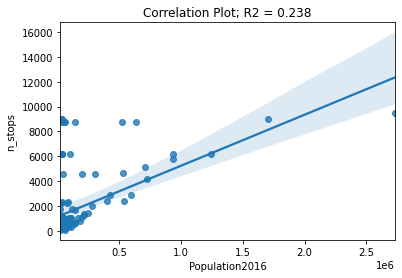

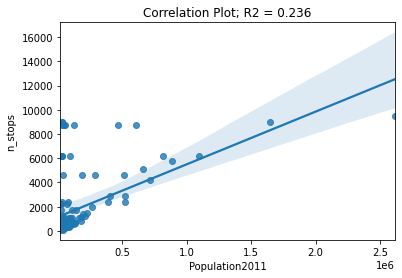

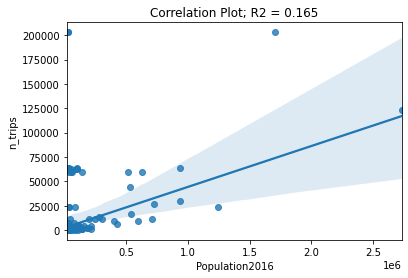

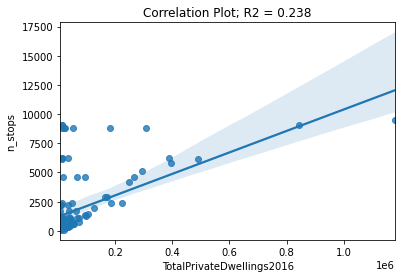

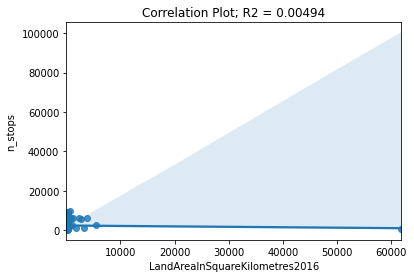

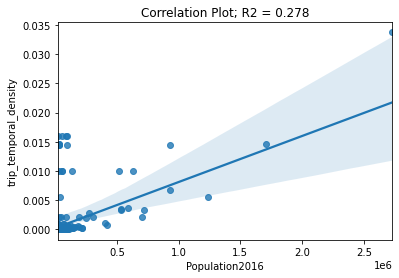

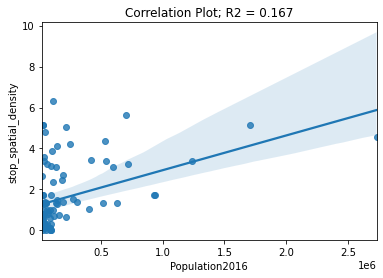

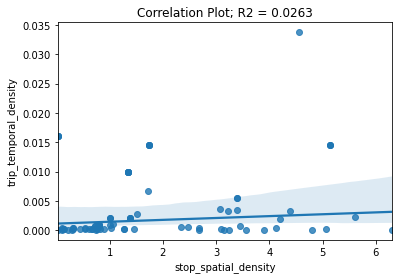

<Figure size 432x288 with 0 Axes>

In [285]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

def r2(x, y):
    return '{0:.3g}'.format(stats.pearsonr(x, y)[0] ** 2)

def create_corr_plot(x, y, save_path):
    ax = sns.regplot(x=df_all[x], y=df_all[y], robust=True)
    ax.set_title(f"Correlation Plot; R2 = {r2(df_all[x], df_all[y])}")
    plt.savefig(save_path)
    plt.show()
    plt.clf()
    
fig_path = "../figures/"
pairs = [
    ("Population2016", "n_stops"),
    ("Population2011", "n_stops"),
    ("Population2016", "n_trips"),
    ("TotalPrivateDwellings2016", "n_stops"),
    ("LandAreaInSquareKilometres2016", "n_stops"),
    ("Population2016", "trip_temporal_density"),
    ("Population2016", "stop_spatial_density"),
    ("stop_spatial_density", 'trip_temporal_density')
]
    
for pair in pairs: create_corr_plot(pair[0], pair[1], os.path.join(fig_path, f"{pair[0]}_{pair[1]}.svg"))

In [130]:
# Prepare all of our variables of interests for a large-scale correlation table

corr_table_y = ['Population2016', 'Population2011',
       'PopulationPercentChange', 'TotalPrivateDwellings2016',
       'TotalPrivateDwellings2011', 'TotalPrivateDwellingsPercentChange',
       'PrivateDwellingsOccupiedByUsualResidents2016',
       'PrivateDwellingsOccupiedByUsualResidents2011',
       'PrivateDwellingsOccupiedByUsualResidentsPercentChange',
       'LandAreaInSquareKilometres2016',
       'PopulationDensityPerSquareKilometre2016', 'NationalPopulationRank2016',
       'ProvincialTerritorialPopulationRank2016']

corr_table_x = ['n_routes', 'n_stops',
       'n_trips', 'n_days', 'height_km', 'width_km', 'ut_start', 'ut_end',
       'stop_spatial_density', 'trip_temporal_density']

# Compute the pearson and spearman correlation for all paired values
csv_output = [['Census-Value'] + ['Correlation'] + corr_table_x]
for census_val in corr_table_y:
    pearson_row  = [census_val] + ['Pearson']
    spearman_row = [census_val] + ['Spearman']
    for gtfs_val in corr_table_x:
        #print(f'Getting correlations for {census_val} and {gtfs_val}')
        pearson  = stats.pearsonr(df_all[census_val], df_all[gtfs_val])[0]
        spearman = stats.spearmanr(df_all[census_val], df_all[gtfs_val])[0]
    
        pearson_row.append(pearson)
        spearman_row.append(spearman)
    csv_output.append(pearson_row)
    csv_output.append(spearman_row)

out = []
for row in csv_output: out.append(','.join(map(str, row)))

# Save to file to colour and clean up manually
open('../tables/complete_correlation_table.csv', 'w').write('\n'.join([row for row in out]))

Getting correlations for Population2016 and n_routes
Getting correlations for Population2016 and n_stops
Getting correlations for Population2016 and n_trips
Getting correlations for Population2016 and n_days
Getting correlations for Population2016 and height_km
Getting correlations for Population2016 and width_km
Getting correlations for Population2016 and ut_start
Getting correlations for Population2016 and ut_end
Getting correlations for Population2016 and stop_spatial_density
Getting correlations for Population2016 and trip_temporal_density
Getting correlations for Population2011 and n_routes
Getting correlations for Population2011 and n_stops
Getting correlations for Population2011 and n_trips
Getting correlations for Population2011 and n_days
Getting correlations for Population2011 and height_km
Getting correlations for Population2011 and width_km
Getting correlations for Population2011 and ut_start
Getting correlations for Population2011 and ut_end
Getting correlations for Popula

6433

## Prepare an Over-/Under-Representation Figure

To illustrate the biases of our collected GTFS data, we with to express the percent difference between the number of CSDs with population > 20K in a given province/territory versus the number of CSDs with population > 20k AND has validated GTFS data in a given province/territory. Those with a percent change close to 0% are unbiased whereas those with a large positive percentage change are over-represented and those with a large negative percent change are under-represented.

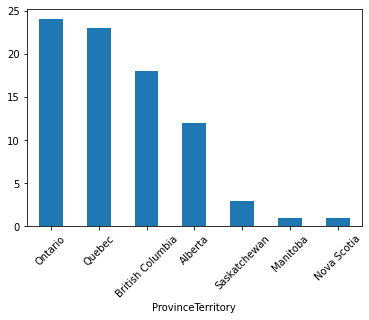

In [150]:

df_all.groupby(['ProvinceTerritory']).size().sort_values(ascending=False).plot(kind = "bar", sort_columns=True,rot=45)

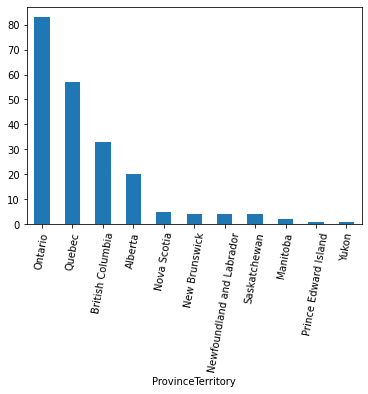

In [155]:
df_raw.groupby(['ProvinceTerritory']).size().sort_values(ascending=False).plot(kind = "bar", sort_columns=True,rot=80)

In [165]:
df_raw.groupby(['ProvinceTerritory']).size().sort_values(ascending=False)

ProvinceTerritory
Ontario                      83
Quebec                       57
British Columbia             33
Alberta                      20
Nova Scotia                   5
New Brunswick                 4
Newfoundland and Labrador     4
Saskatchewan                  4
Manitoba                      2
Prince Edward Island          1
Yukon                         1
dtype: int64

In [177]:
total_CSD_pop_over20k = df_raw.shape[0]
total_CSD_pop_over20k_wGTFS = df_clean.shape[0]
print(f"Total number of CSD with Pop. over 20K: {total_CSD_pop_over20k}\nTotal number of CSD with Pop. over 20K with GTFS: {total_CSD_pop_over20k_wGTFS}")

# Used to normalize the number of CSDs over 20k
def div_by_total_CSD20k(x):
    return x/total_CSD_pop_over20k

# Used to normalize the number of CSDs over 20k with GTFS data
def div_by_total_CSD20k_wGTFS(x):
    return x/total_CSD_pop_over20k_wGTFS

raw_counts = df_raw.groupby(['ProvinceTerritory']).size().sort_values(ascending=False)
raw_norm_counts = raw_counts.apply(div_by_total_CSD20k)
raw_norm_counts = raw_norm_counts.rename("raw")

clean_counts = df_all.groupby(['ProvinceTerritory']).size().sort_values(ascending=False)
clean_norm_counts = clean_counts.apply(div_by_total_CSD20k_wGTFS)
clean_norm_counts = clean_norm_counts.rename("clean")

Total number of CSD with Pop. over 20K: 214
Total number of CSD with Pop. over 20K with GTFS: 82


In [178]:
raw_norm_counts

ProvinceTerritory
Ontario                      0.387850
Quebec                       0.266355
British Columbia             0.154206
Alberta                      0.093458
Nova Scotia                  0.023364
New Brunswick                0.018692
Newfoundland and Labrador    0.018692
Saskatchewan                 0.018692
Manitoba                     0.009346
Prince Edward Island         0.004673
Yukon                        0.004673
Name: raw, dtype: float64

In [179]:
clean_norm_counts

ProvinceTerritory
Ontario             0.292683
Quebec              0.280488
British Columbia    0.219512
Alberta             0.146341
Saskatchewan        0.036585
Manitoba            0.012195
Nova Scotia         0.012195
Name: clean, dtype: float64

In [188]:
df_merge = pd.merge(raw_norm_counts, clean_norm_counts, right_index = True, left_index = True)

In [189]:
df_merge['diff_percentage'] = df_merge.apply(lambda row: (row.clean - row.raw) * 100, axis=1)
df_merge

,raw,clean,diff_percentage
ProvinceTerritory,,,
Ontario,0.387850,0.292683,-9.516754
Quebec,0.266355,0.280488,1.413266
British Columbia,0.154206,0.219512,6.530659
Alberta,0.093458,0.146341,5.288352
Nova Scotia,0.023364,0.012195,-1.116936
Saskatchewan,0.018692,0.036585,1.789378
Manitoba,0.009346,0.012195,0.284933


-9.516754046045135
-1.1169364030088897
0.28493275586961486
1.4132664691132946
1.7893777068611807
5.28835194894005
6.530658764531571


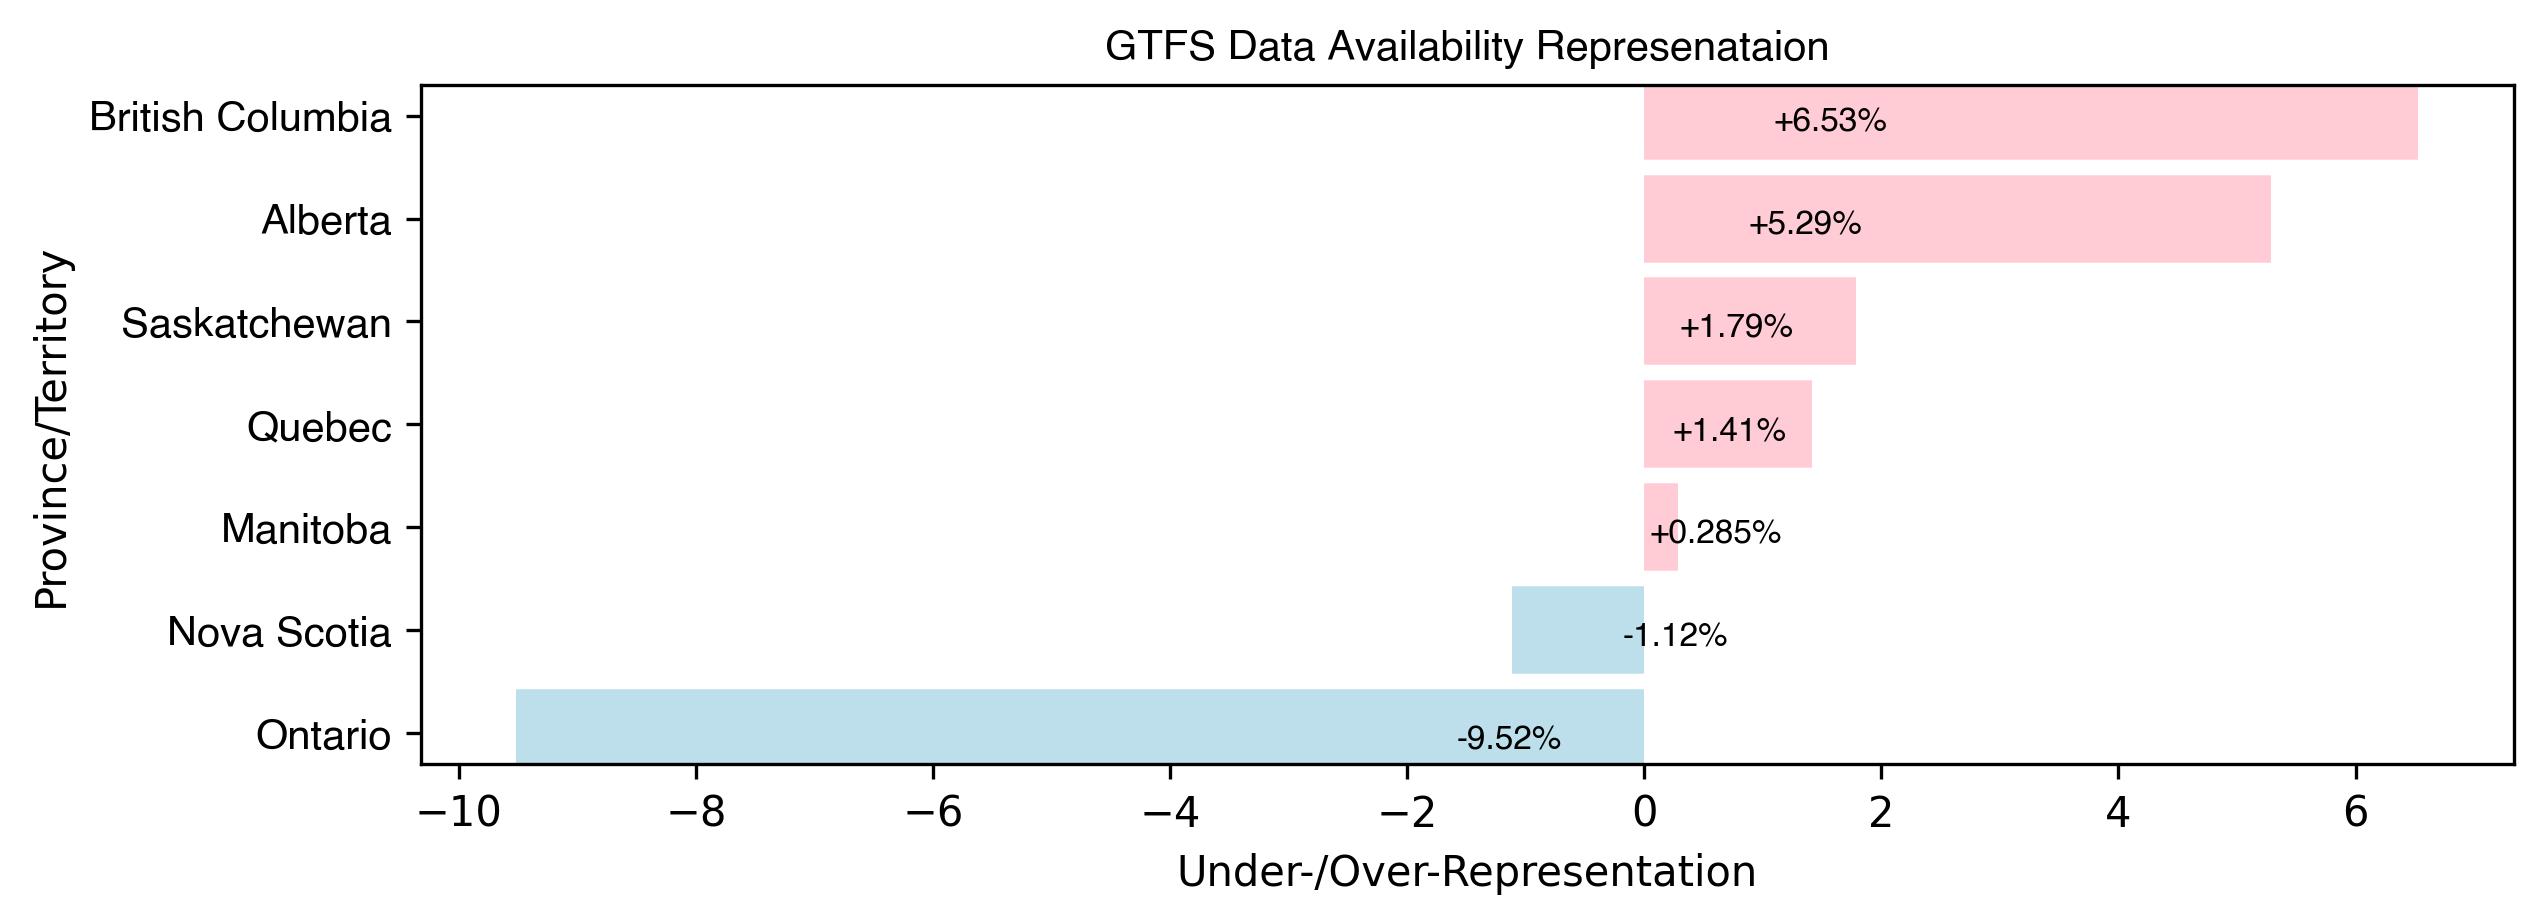

In [284]:
import matplotlib.ticker as ticker
hfont = {'fontname':'Helvetica'}

for i in range(df_merge.shape[0]):
    df_merge['color'] = ['lightblue' if float(x) < 0 else 'pink' for x in df_merge['diff_percentage']]
  
# Sort values from lowest to highest
df_merge.sort_values('diff_percentage', inplace=True)
  
# Resets initial index in Dataframe to None
#df_merge.reset_index(inplace=True)
  
# Draw plot
plt.figure(figsize=(9, 3), dpi=300)
  
# Plotting the horizontal lines
plt.hlines(y=df_merge.index, xmin=0, xmax=df_merge.diff_percentage, color=df_merge.color, alpha=0.8, linewidth=21)
  
# Decorations
# Setting the labels of x-axis and y-axis
plt.gca().set(ylabel='Province/Territory', xlabel='Under-/Over-Representation')

# Title of Bar Chart
plt.title('GTFS Data Availability Represenataion', fontdict={'size': 10}, **hfont)
plt.yticks(range(0,len(df_merge.index)), df_merge.sort_values(by='diff_percentage', ascending=True)['ProvinceTerritory'], **hfont)

# TODO: Figure out adding values to these plots
for idx, val in enumerate(df_merge.sort_values(by='diff_percentage', ascending=True)['diff_percentage']):
    print(val)
    ann = '{0:.3g}%'.format(val)
    if val > 0: ann = '+' + ann
    plt.annotate(ann, xy=(val/2, idx),xytext=(val/6, idx-0.15), size=8, **hfont)

plt.savefig('../figures/GTFS-data-avilability-representation.svg')

In [260]:
df_merge.sort_values(by='diff_percentage', ascending=True)

,level_0,index,ProvinceTerritory,raw,clean,diff_percentage,color
0,0,0,Ontario,0.387850,0.292683,-9.516754,lightblue
1,1,1,Nova Scotia,0.023364,0.012195,-1.116936,lightblue
2,2,2,Manitoba,0.009346,0.012195,0.284933,pink
3,3,3,Quebec,0.266355,0.280488,1.413266,pink
4,4,4,Saskatchewan,0.018692,0.036585,1.789378,pink
5,5,5,Alberta,0.093458,0.146341,5.288352,pink
6,6,6,British Columbia,0.154206,0.219512,6.530659,pink
